In [11]:
# imports used to manipulate data and describe the data with plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# POST MVP

MVP
- created two data sets
    - game by game statistics (each row accounts for a single game)
    - aggregated statistics (each row accounts for all games up to that game)
- feature selection process that produced similar but slightly worse predictions
- xgboost model predicting with 58% accuracy

Post MVP plans
- make predicitons on a single season
- identify optimal number of games for statistics to aggregate
- neural net for predictions
- allow game by game predictions usable with gui or interface of some sort

# Single Season Predictions
For this experiment I am going to be using the best performing model (XGBoost) with optimal parameters to make predictions on a single season. The test set is going to be the 2019 season.

In [24]:
# importing aggregate data and dropping unnamed
df = pd.read_csv('data/agg_data_final.csv')
# away outcome dropped becuase predicting based on home team
df.drop(columns=['Unnamed: 0','away_outcome_nonagg'],inplace=True)

In [25]:
# convering date column from object to datetime
df.Date = pd.to_datetime(df.Date,format='%Y-%m-%d')

In [90]:
# creating train test split manually
train_set = df[(df.Date.dt.year != 2019)]
test_set = df[(df.Date.dt.year == 2019)]

# going to order test set because if used in real time would only have games coming in order of date
test_set.sort_values(by=['Date'],inplace=True)

# going to drop the first 10 games of each season from train
train_set = train_set[(df.game_number_of_season > 10)]

In [91]:
# creating x and y from train (all games not in 2019)
X_train = train_set.drop(columns='home_outcome_nonagg')
y_train = train_set['home_outcome_nonagg']

# creating x and y from test (all 2019 games)
X_test = test_set.drop(columns='home_outcome_nonagg')
y_test = test_set['home_outcome_nonagg']

In [92]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic',
                                 learning_rate = 0.01,
                                 max_depth = 5,
                                 min_child_weight = 2,
                                 n_estimators = 300)
# dropping 3 columns that are not used for prediction
xgb_model.fit(X_train.drop(columns=['home_team','away_team','Date']),
              y_train)

XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=2,
              n_estimators=300, objective='multi:softprob')

In [93]:
xgb_model_predictions_train = xgb_model.predict(X_train.drop(columns=['home_team','away_team','Date']))
xgb_model_predictions_test = xgb_model.predict(X_test.drop(columns=['home_team','away_team','Date']))
train_acc = accuracy_score(y_train, xgb_model_predictions_train)
test_acc = accuracy_score(y_test, xgb_model_predictions_test)
print("Train Accuracy: %f" % (train_acc))
print("Test Accuracy: %f" % (test_acc))

Train Accuracy: 0.617475
Test Accuracy: 0.598616


In [80]:
# looking at when we are predicting the best
# accuracy over whole season
accuracy_whole = 0
# past games right or wrongs
game_preds = []
# list to hold game rolling accuracy throuhgout whole season to see how we do as season goes on
accuracy_rolling_season = []
# number of games seen
num_of_games = 0
# correct predictions
num_right = 0
# wrong predictions
num_wrong = 0
# number of games for rolling
rolling_number = 50

for true,pred in zip(y_test,xgb_model_predictions_test):
    # after seeing rolling number of games
    if num_of_games > rolling_number:
        # get rid of least recent game, using append so most recent game at end
        game_preds = game_preds[1:]
    # every period of rolling games calculate the rolling accuracy
    if num_of_games % rolling_number == 0:
        # calcuate rolling game accuracy and append to season list
        accuracy_rolling_season.append(sum(game_preds)/rolling_number)
    # one more game seen
    num_of_games +=1
    # correct prediction
    if pred == true:
        num_right += 1
        game_preds.append(1)
    # wrong prediction
    else:
        num_wrong +=1
        game_preds.append(0)
accuracy_whole = num_right/num_of_games

print('Number of games right: {}'.format(num_right))
print('Number of games wrong: {}'.format(num_wrong))
print('Best rolling game streak: {}'.format(max(accuracy_rolling_season)))
print('Season Accuracy: {}'.format(accuracy_whole))

Number of games right: 1730
Number of games wrong: 1160
Best rolling game streak: 0.82
Season Accuracy: 0.5986159169550173


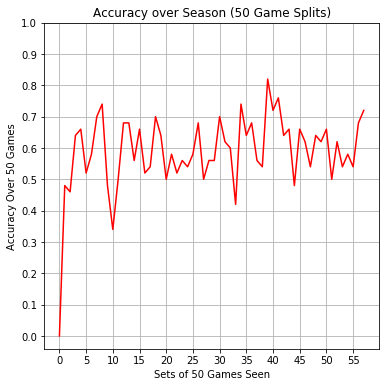

In [108]:
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(accuracy_rolling_season,color='red')
ax.set_xlabel('Sets of 50 Games Seen')
ax.set_ylabel('Accuracy Over 50 Games')
ax.set_yticks(np.linspace(0,1,11))
ax.set_xticks(range(0,round(num_of_games/50),5))
ax.set_title('Accuracy over Season (50 Game Splits)')
ax.grid();

# Optimal Game Number Buffer
When using aggregated statistics it is useful to not predict on the games at the start of the season as the aggregated statistics have not had enought time to really show how well that team performs. Allowing a 10 game buffer would allow us to build up the statistics and then by the 11th game we have a much better idea on how each team will perform allowing for better predictions.

In [157]:
def xg_prediction(buffer):
    # creating train test split manually
    X = df.drop(columns='home_outcome_nonagg')
    y = df.home_outcome_nonagg
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=49)
    # get rid of games in train before buffer number
    # combine x and y so they dont get mixed
    train = pd.concat([X_train,y_train],axis=1)
    # get rid of games before buffer game number
    train = train[(train.game_number_of_season>buffer)]
    # make x and y train
    X_train = train.drop(columns='home_outcome_nonagg')
    y_train = train.home_outcome_nonagg
    
    
    #run model
    xgb_model_buffer = xgb.XGBClassifier(objective = 'binary:logistic',
                                 learning_rate = 0.01,
                                 max_depth = 5,
                                 min_child_weight = 2,
                                 n_estimators = 300)
    # dropping 3 columns that are not used for prediction
    xgb_model_buffer.fit(X_train.drop(columns=['home_team','away_team','Date']),
                  y_train)
    
    xgb_model_buffer_predictions_train = xgb_model_buffer.predict(X_train.drop(columns=['home_team','away_team','Date']))
    xgb_model_buffer_predictions_test = xgb_model_buffer.predict(X_test.drop(columns=['home_team','away_team','Date']))
    train_acc_buffer = accuracy_score(y_train, xgb_model_buffer_predictions_train)
    test_acc_buffer = accuracy_score(y_test, xgb_model_buffer_predictions_test)
    print("Train Accuracy: %f" % (train_acc_buffer))
    print("Test Accuracy: %f" % (test_acc_buffer))
    return train_acc,test_acc

In [158]:
scores_per_buffer = []
for buffer in range(0,35,5):
    train_acc,test_acc = xg_prediction(buffer)
    scores_per_buffer.append((train_acc,test_acc))

Train Accuracy: 0.624246
Test Accuracy: 0.583405
Train Accuracy: 0.625509
Test Accuracy: 0.579314
Train Accuracy: 0.627203
Test Accuracy: 0.573572
Train Accuracy: 0.628108
Test Accuracy: 0.575510
Train Accuracy: 0.628865
Test Accuracy: 0.574218
Train Accuracy: 0.637930
Test Accuracy: 0.575366
Train Accuracy: 0.639208
Test Accuracy: 0.572208


From this we can see that as we reduce the number of games seen when fitting the model the better we perfom on the training set but the worse we perform on the test set. This means that in the training set we should keep the entire dataset for training.

# Optimal Game Number to start predicting

In [167]:
# creating train test split manually
X = df.drop(columns='home_outcome_nonagg')
y = df.home_outcome_nonagg

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=49)

#run model
xgb_model_buffer = xgb.XGBClassifier(objective = 'binary:logistic',
                             learning_rate = 0.01,
                             max_depth = 5,
                             min_child_weight = 2,
                             n_estimators = 300)
# dropping 3 columns that are not used for prediction
xgb_model_buffer.fit(X_train.drop(columns=['home_team','away_team','Date']),
              y_train)

xgb_model_buffer_predictions_train = xgb_model_buffer.predict(X_train.drop(columns=['home_team','away_team','Date']))
xgb_model_buffer_predictions_test = xgb_model_buffer.predict(X_test.drop(columns=['home_team','away_team','Date']))
train_acc_buffer = accuracy_score(y_train, xgb_model_buffer_predictions_train)
test_acc_buffer = accuracy_score(y_test, xgb_model_buffer_predictions_test)
print("Train Accuracy: %f" % (train_acc_buffer))
print("Test Accuracy: %f" % (test_acc_buffer))

Train Accuracy: 0.624246
Test Accuracy: 0.583405


In [168]:

for buffer in range(0,85,5):
    test = pd.concat([X_test,y_test],axis=1)
    # get rid of games before buffer game number
    test = test[(test.game_number_of_season>buffer)]
    print(test.shape)
    # make x and y train
    X_test = test.drop(columns='home_outcome_nonagg')
    y_test = test.home_outcome_nonagg
    xgb_model_buffer_predictions_test = xgb_model_buffer.predict(X_test.drop(columns=['home_team','away_team','Date']))
    test_acc_buffer = accuracy_score(y_test, xgb_model_buffer_predictions_test)
    print("Test Accuracy: {} with buffer {}".format(test_acc_buffer,buffer))

(13932, 81)
Test Accuracy: 0.5834051105368935 with buffer 0
(13123, 81)
Test Accuracy: 0.5850796311818944 with buffer 5
(12297, 81)
Test Accuracy: 0.5844514922338782 with buffer 10
(11465, 81)
Test Accuracy: 0.5861317051897078 with buffer 15
(10594, 81)
Test Accuracy: 0.589012648669058 with buffer 20
(9795, 81)
Test Accuracy: 0.5883614088820827 with buffer 25
(8949, 81)
Test Accuracy: 0.5925801765560398 with buffer 30
(8117, 81)
Test Accuracy: 0.5954170259948257 with buffer 35
(7235, 81)
Test Accuracy: 0.596682791983414 with buffer 40
(6385, 81)
Test Accuracy: 0.5970242756460454 with buffer 45
(5515, 81)
Test Accuracy: 0.600362647325476 with buffer 50
(4676, 81)
Test Accuracy: 0.6002994011976048 with buffer 55
(3787, 81)
Test Accuracy: 0.5996831264853446 with buffer 60
(2908, 81)
Test Accuracy: 0.5993810178817056 with buffer 65
(2017, 81)
Test Accuracy: 0.6078334159643034 with buffer 70
(1124, 81)
Test Accuracy: 0.6263345195729537 with buffer 75
(145, 81)
Test Accuracy: 0.6413793103448

From this we can see that as time goes on we greatly improve accuracy on the test set. This means that as the season goes on we have a much better chance of predicting the outcome correctly.